In [1]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np

In [2]:
# Create list of all targets (minus background noise)
dataset_path = '/home/ubuntu/project/dataset/speech_commands_v0.02'
# all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets = [name for name in listdir(dataset_path) if name in ["_background_noise_",'yes','no','stop']]

all_targets.remove('_background_noise_')
print(all_targets)

['stop', 'no', 'yes']


In [3]:
!pwd


/home/ubuntu/project/tflite-speech-recognition


In [4]:
# Settings
feature_sets_path = '/home/ubuntu/project/tflite-speech-recognition'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_filename = 'wake_word_yes_model.h5'
wake_word = 'yes'

In [5]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [6]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [7]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(8767, 16, 16)
(1089, 16, 16)
(1091, 16, 16)


In [8]:
# Peek at labels
print(y_val)

[0. 0. 1. ... 2. 0. 1.]


In [9]:
# Convert ground truth arrays to one wake word (1) and 'other' (0)
wake_word_index = all_targets.index(wake_word)
y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')

In [10]:
# Peek at labels after conversion
print(y_val)

[0. 0. 0. ... 1. 0. 0.]


In [11]:
# What percentage of 'stop' appear in validation labels
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))

0.3333333333333333
0.6666666666666667


In [12]:
# View the dimensions of our input data
print(x_train.shape)

(8767, 16, 16)


In [13]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(8767, 16, 16, 1)
(1089, 16, 16, 1)
(1091, 16, 16, 1)


In [14]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [15]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [16]:
# Display model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 15, 15, 32)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 32)          4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

In [17]:
# Add training parameters to model
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])

In [18]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=150, 
                    batch_size=100, 
                    validation_data=(x_val, y_val))

Epoch 1/150
88/88 [==============================] - 1s 9ms/step - loss: 0.3311 - acc: 0.8582 - val_loss: 0.2436 - val_acc: 0.8981
Epoch 2/150
88/88 [==============================] - 0s 5ms/step - loss: 0.1813 - acc: 0.9288 - val_loss: 0.1182 - val_acc: 0.9559
Epoch 3/150
88/88 [==============================] - 0s 5ms/step - loss: 0.1427 - acc: 0.9457 - val_loss: 0.1008 - val_acc: 0.9596
Epoch 4/150
88/88 [==============================] - 0s 5ms/step - loss: 0.1123 - acc: 0.9583 - val_loss: 0.0869 - val_acc: 0.9660
Epoch 5/150
88/88 [==============================] - 0s 5ms/step - loss: 0.0965 - acc: 0.9634 - val_loss: 0.0967 - val_acc: 0.9669
Epoch 6/150
88/88 [==============================] - 0s 5ms/step - loss: 0.0900 - acc: 0.9677 - val_loss: 0.0679 - val_acc: 0.9752
Epoch 7/150
88/88 [==============================] - 0s 5ms/step - loss: 0.0771 - acc: 0.9713 - val_loss: 0.1134 - val_acc: 0.9550
Epoch 8/150
88/88 [==============================] - 0s 6ms/step - loss: 0.0703 - a

88/88 [==============================] - 0s 6ms/step - loss: 0.0069 - acc: 0.9978 - val_loss: 0.1102 - val_acc: 0.9835
Epoch 64/150
88/88 [==============================] - 0s 6ms/step - loss: 0.0042 - acc: 0.9986 - val_loss: 0.1506 - val_acc: 0.9816
Epoch 65/150
88/88 [==============================] - 0s 6ms/step - loss: 0.0083 - acc: 0.9978 - val_loss: 0.2199 - val_acc: 0.9706
Epoch 66/150
88/88 [==============================] - 1s 6ms/step - loss: 0.0049 - acc: 0.9981 - val_loss: 0.1509 - val_acc: 0.9826
Epoch 67/150
88/88 [==============================] - 0s 6ms/step - loss: 0.0049 - acc: 0.9989 - val_loss: 0.1527 - val_acc: 0.9816
Epoch 68/150
88/88 [==============================] - 0s 6ms/step - loss: 0.0035 - acc: 0.9989 - val_loss: 0.2540 - val_acc: 0.9770
Epoch 69/150
88/88 [==============================] - 1s 6ms/step - loss: 0.0065 - acc: 0.9977 - val_loss: 0.1559 - val_acc: 0.9826
Epoch 70/150
88/88 [==============================] - 0s 6ms/step - loss: 0.0046 - acc: 0

Epoch 125/150
88/88 [==============================] - 1s 6ms/step - loss: 0.0033 - acc: 0.9993 - val_loss: 0.2537 - val_acc: 0.9798
Epoch 126/150
88/88 [==============================] - 0s 6ms/step - loss: 0.0043 - acc: 0.9995 - val_loss: 0.2268 - val_acc: 0.9807
Epoch 127/150
88/88 [==============================] - 0s 6ms/step - loss: 0.0019 - acc: 0.9994 - val_loss: 0.2404 - val_acc: 0.9798
Epoch 128/150
88/88 [==============================] - 0s 6ms/step - loss: 8.3973e-04 - acc: 0.9998 - val_loss: 0.3038 - val_acc: 0.9798
Epoch 129/150
88/88 [==============================] - 1s 6ms/step - loss: 0.0036 - acc: 0.9994 - val_loss: 0.3175 - val_acc: 0.9807
Epoch 130/150
88/88 [==============================] - 0s 6ms/step - loss: 0.0067 - acc: 0.9989 - val_loss: 0.2984 - val_acc: 0.9807
Epoch 131/150
88/88 [==============================] - 1s 6ms/step - loss: 4.7973e-05 - acc: 1.0000 - val_loss: 0.3185 - val_acc: 0.9752
Epoch 132/150
88/88 [==============================] - 0s 6ms

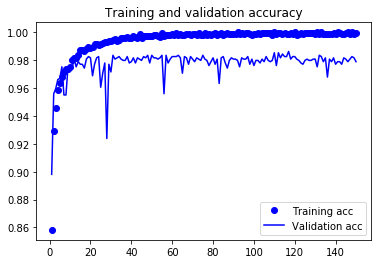

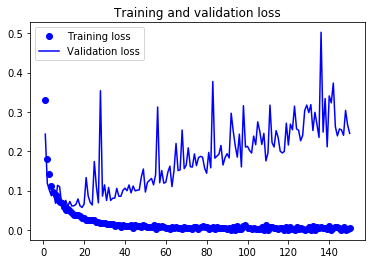

In [19]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
# Save the model as a file
models.save_model(model, model_filename)

In [21]:
# See which are 'stop'
for idx, y in enumerate(y_test):
    if y == 1:
        print(idx)

7
11
12
17
21
23
28
29
34
35
37
38
41
42
43
50
54
61
66
69
73
75
76
77
81
84
86
87
88
92
93
97
98
99
101
105
106
107
109
110
114
115
119
123
133
135
138
141
142
143
150
152
154
155
159
163
166
170
174
175
179
192
193
201
204
207
208
213
214
220
221
222
230
232
233
235
237
240
243
245
250
251
259
263
267
269
271
275
276
279
280
283
289
292
296
298
303
306
310
313
314
315
320
321
322
324
325
326
333
336
342
343
348
350
352
355
356
359
361
365
368
369
370
375
378
381
387
396
397
398
400
402
406
409
411
413
414
419
420
421
427
428
430
436
437
438
441
443
453
457
460
473
475
478
481
482
483
489
493
495
498
500
501
502
504
505
510
513
515
521
523
527
528
529
533
538
539
541
544
546
547
550
555
556
560
562
565
566
567
576
578
579
580
593
594
608
613
614
622
623
624
625
627
629
632
633
634
636
640
641
644
648
649
650
653
655
656
659
660
661
663
664
669
671
673
676
677
679
682
683
684
690
691
694
696
697
700
705
711
715
720
722
723
725
730
731
740
741
749
751
753
754
756
762
763
765
767
768
779

In [22]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(100, 110):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

Answer: 0.0  Prediction: [[1.2841192e-29]]
Answer: 1.0  Prediction: [[1.]]
Answer: 0.0  Prediction: [[3.932928e-16]]
Answer: 0.0  Prediction: [[4.630429e-31]]
Answer: 0.0  Prediction: [[2.0132426e-27]]
Answer: 1.0  Prediction: [[1.]]
Answer: 1.0  Prediction: [[1.]]
Answer: 1.0  Prediction: [[1.]]
Answer: 0.0  Prediction: [[6.36379e-30]]
Answer: 1.0  Prediction: [[1.]]


In [23]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

35/35 [==============================] - 0s 3ms/step - loss: 0.3331 - acc: 0.9844


[0.33307576179504395, 0.9844179749488831]